TODO: 

In [1]:
import io, json, os, sys
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import zstandard as zstd
from tqdm.notebook import tqdm

In [ ]:
def print_interval(dataframe, lower, upper):
    """used this small function to write different intervals of harmfull_pp and save it to a log file.
    It prints the number of files checked 
    """
    doc_n = 0
    with open ('./interval_log', 'w') as file:
        for row in dataframe.filter((pl.col('harmful_pp') > lower) & (pl.col('harmful_pp') < upper)).select(['content','harmful_pp']).iter_rows():
            file.write(str(row[1]) + ' - ' + row[0] +'\n\n')
            doc_n +=1
    print(doc_n)

# Functions to filter the nested jsons
def return_tlsh(dataframe):
    return dataframe['tlsh']

def return_pp(dataframe):
    return dataframe['harmful_pp']

def return_qw(dataframe):
    return dataframe['quality_warnings']

# Filtering adult content
def is_adult(tags):
    """Removes adult content, returning False, mean that the DF will not keep the row
    """
    try:
        if 'adult' in tags:
            return False
        else:
            return True
    except TypeError:
        return True

In [4]:
#path = "/ds/text/oscar/oscar-2301/krc_meta/krc_meta.jsonl.zst"
path = "./dataset/pt_meta/pt_meta_part_64.jsonl"

# Polars

In [6]:
# If read from compressed file
read_from_compressed = 0
if read_from_compressed == 1:
    curre_doc = []
    with open(path, 'rb') as fh:
        dctx = zstd.ZstdDecompressor()
        stream_reader = dctx.stream_reader(fh)
        text_stream = io.TextIOWrapper(stream_reader, encoding='utf-8')
        
        for line in text_stream:
            curre_doc.append(json.loads(line))
            if len(curre_doc) == 20000:
                break
    pl_df = pl.DataFrame(curre_doc)
    print(pl_df.head(3))

# if reading from uncompressed file:
if read_from_compressed == 0:
    pl_df = pl.read_ndjson(path)
    print(pl_df.head(3))

shape: (3, 3)
┌────────────────────────────────┬────────────────────────────────┬────────────────────────────────┐
│ content                        ┆ warc_headers                   ┆ metadata                       │
│ ---                            ┆ ---                            ┆ ---                            │
│ str                            ┆ struct[9]                      ┆ struct[6]                      │
╞════════════════════════════════╪════════════════════════════════╪════════════════════════════════╡
│ e ou não em Qualquer campo     ┆ {"897","sha1:NXYA4DGHS3B74CKLJ ┆ {{"pt",0.7385287},13782.712,"t │
│ Títul…                         ┆ ZQ…                            ┆ ls…                            │
│ Jejum natural e Alimentação    ┆ {"3185","sha1:ELEQ2HJXRUROQS5N ┆ {{"pt",0.8846815},3134.7778,"t │
│ Natu…                          ┆ ON…                            ┆ ls…                            │
│ Semana em comemoração ao Dia   ┆ {"3684","sha1:R7AZSF3ICN76X2IN ┆ {{"pt",0.

In [50]:
# filtering out the nested JSONS

tlsh_list = list(map(return_tlsh, pl_df[:,2]))
harmful_pp_list = list(map(return_pp, pl_df[:,2]))
qw_list = list(map(return_qw, pl_df[:,2]))

In [ ]:
# Creating the Dataframe from the nested JSONS

new_df = pl.DataFrame({'content': pl_df[:,0], 'tlsh':tlsh_list, 'harmful_pp':harmful_pp_list, 'quality_warnings':qw_list})
new_df = new_df.sort("harmful_pp")
new_df = new_df.filter(list(map(is_adult, new_df["quality_warnings"])))

#del pl_df

## Qualitative analysis

In [42]:



# for content in new_df.sort('harmful_pp').tail(1000).iter_rows():
#     print("{} - {}\n\n".format(content[0],content[2]))
print_interval(new_df, 2000,2100)

5657


## Plots

In [12]:
def std_filter(dataframe,n_std):
    """Filter the dataframe according to the standard deviation of the harmful_pp
    """
    std = dataframe['harmful_pp'].std()
    mean = dataframe['harmful_pp'].mean()
    lower = mean - n_std*std
    upper = mean + n_std*std
    return dataframe.filter((pl.col('harmful_pp') > lower) & (pl.col('harmful_pp') < upper))

def interval_filter(dataframe, interval:list) -> pl.dataframe:
    return dataframe.filter((pl.col('harmful_pp') > interval[0]) & (pl.col('harmful_pp') < interval[1]))

def str_describe(dataframe,column):
    return '\n'.join([str(row[0]) + '    ' + str(row[1]) for row in dataframe[column].describe().iter_rows()])



In [13]:
sns.set(rc={"figure.figsize":(16, 9)})


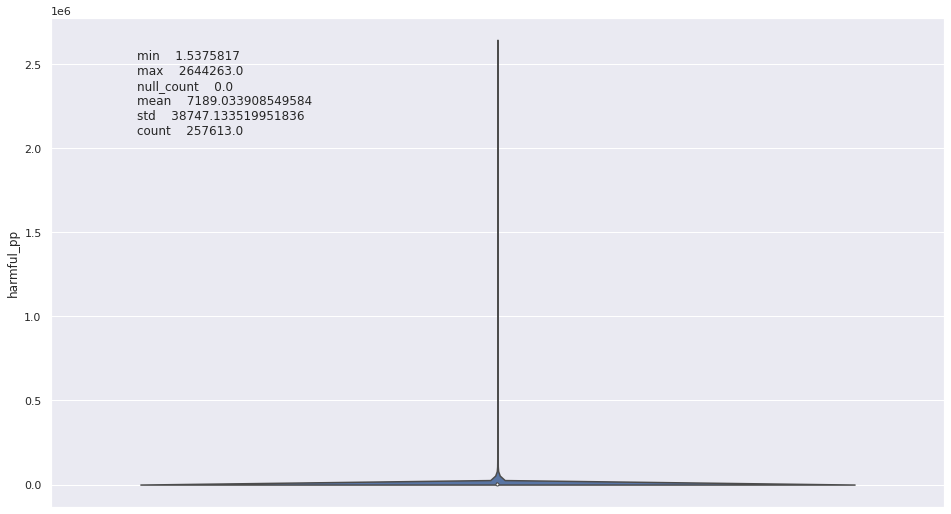

In [14]:
sns.violinplot(y = new_df['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(new_df,'harmful_pp'))
plt.show()

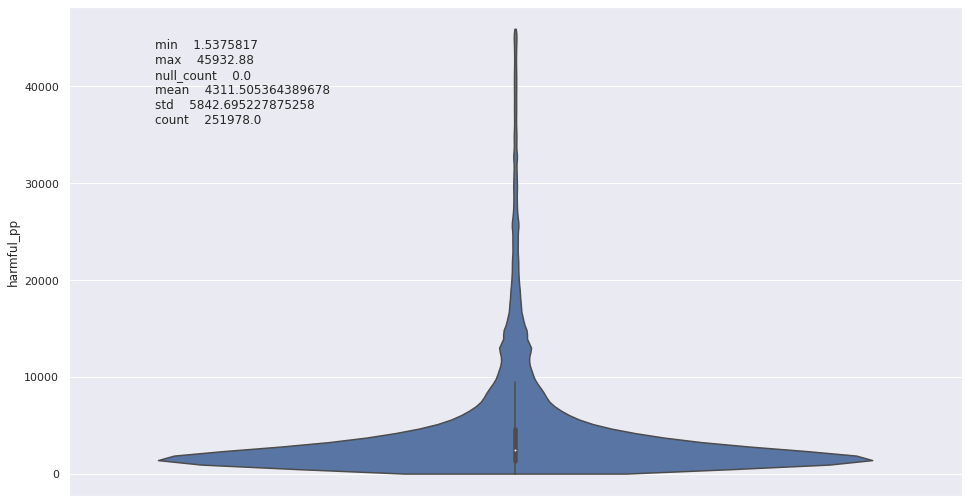

In [15]:
filtered = std_filter(new_df,1)

sns.violinplot(y = filtered['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered,'harmful_pp'))
plt.show()

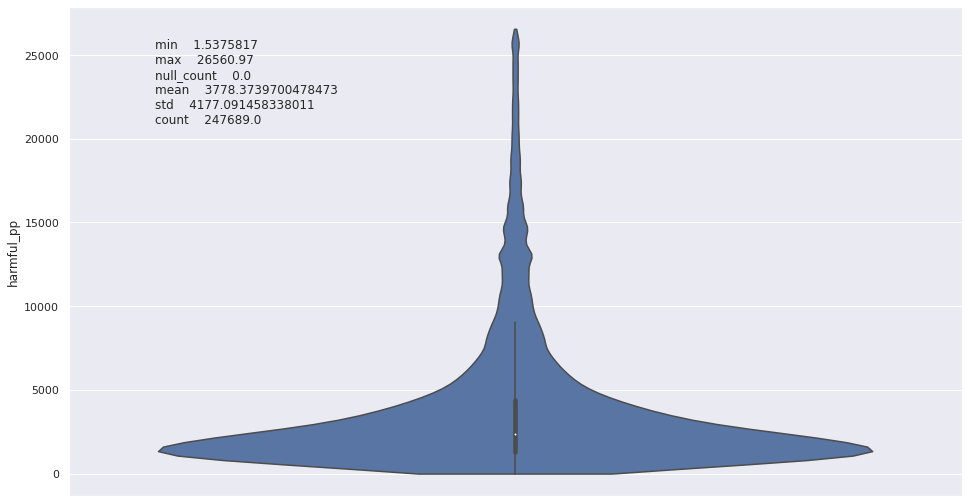

In [22]:
filtered_2 = std_filter(new_df,0.5)

sns.violinplot(y = filtered_2['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered_2,'harmful_pp'))
plt.show()
del filtered_2

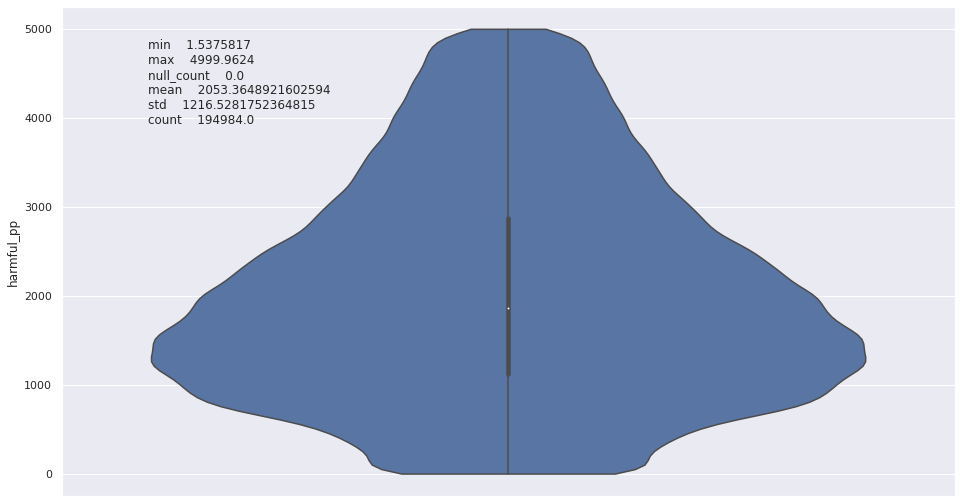

In [18]:
# PLotting filtered by perplexity interval - 0:20

filtered_perplexity = interval_filter(new_df,[0,5000])
sns.violinplot(y = filtered_perplexity['harmful_pp'],cut=0)
plt.figtext(0.2, 0.7, str_describe(filtered_perplexity,'harmful_pp'))
plt.show()
del filtered_perplexity

In [58]:
# Testing for erasing DF if there is no Perplexity measure

df = new_df.drop_nulls()
print(df)

if df.is_empty():
    print('o')

shape: (0, 4)
┌─────────┬──────┬────────────┬──────────────────┐
│ content ┆ tlsh ┆ harmful_pp ┆ quality_warnings │
│ ---     ┆ ---  ┆ ---        ┆ ---              │
│ str     ┆ str  ┆ f64        ┆ list[str]        │
╞═════════╪══════╪════════════╪══════════════════╡
└─────────┴──────┴────────────┴──────────────────┘
o
